In [1]:
# Load packages

import pandas as pd
import altair as alt
import numpy as np

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
alt.data_transformers.enable('json')

from vega_datasets import data

In [2]:
jobs = data.jobs()


In [3]:
grouped_jobs = jobs.pivot_table(
  columns=['sex'], 
  values=['count', 'perc'], 
  index=['year', 'job']
)

In [4]:
# Categorize each row into a gender dominant group 
# based on its male to female ratio of that year
def categorize_gender_dominant_group(row):  
  male_count = row['count']['men']
  female_count = row['count']['women']
  
  if male_count == 0 and female_count == 0:
    return 'no job'
  elif row['count']['women'] == 0:
    return 'only male'
  elif row['count']['men'] == 0:
    return 'only female'
  elif (male_count/female_count) >= 2:
    return 'male dominant'
  elif (male_count/female_count) <= 0.5:
    return 'female dominant'
  else:
    return 'balanced'

In [5]:
grouped_jobs['gender_dominant_group'] = grouped_jobs.apply(categorize_gender_dominant_group, axis=1)

In [6]:
grouped_jobs = grouped_jobs[grouped_jobs['gender_dominant_group'] != 'no job']



In [7]:
gender_dominant_group_count_df = (
  grouped_jobs.groupby(['year', 'gender_dominant_group']).size().unstack(fill_value = 0)
)

In [8]:
gender_dominant_group_count_df = gender_dominant_group_count_df.reset_index()

In [9]:
gender_dominant_group_count_df.columns.name = ''

In [10]:
# Set the total column
gender_dominant_group_count_df['total'] = gender_dominant_group_count_df.loc[
  :, gender_dominant_group_count_df.columns != 'year'
].apply(sum, axis = 1)

gender_dominant_group_count_df = gender_dominant_group_count_df[['year','only male','male dominant','balanced', 'female dominant', 'only female', 'total']]

In [11]:
gender_dominant_group_count_df.head()

,year,only male,male dominant,balanced,female dominant,only female,total
0,1850,112,38,2,3,1,156
1,1860,92,63,12,8,2,177
2,1870,94,71,13,9,2,189
3,1880,88,78,12,10,1,189
4,1900,64,123,20,15,2,224


In [12]:
gender_dominant_group_count_df = gender_dominant_group_count_df.drop('total', axis=1)

In [13]:
gender_dominant_group_count_df = gender_dominant_group_count_df.melt(
  id_vars=['year'],
  var_name='job_gender_dominant_group', 
  value_name='total'
)

In [14]:
def sort_order(col_val):
    if col_val == 'only male':
        return 1
    elif col_val == 'male dominant':
        return 2
    elif col_val == 'balanced':
        return 3
    elif col_val == 'female dominant':
        return 4
    else:
        return 5



In [15]:
gender_dominant_group_count_df['sort_order'] = gender_dominant_group_count_df['job_gender_dominant_group'].apply(sort_order)



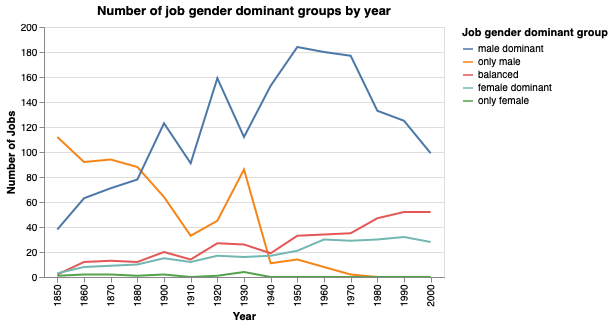

In [16]:
gender_group_chart2 = alt.Chart(gender_dominant_group_count_df).mark_line().encode(
  x=alt.X('year:O', axis=alt.Axis(title='Year')),
  y=alt.Y('total', axis=alt.Axis(title='Number of Jobs')),
  color=alt.Color('job_gender_dominant_group', legend=alt.Legend(title="Job gender dominant group"), sort = ['male dominant','only male','balanced', 'female dominant', 'only female'])
).properties(
  title='Number of job gender dominant groups by year',
    height = 250,
    width = 400
)

gender_group_chart2

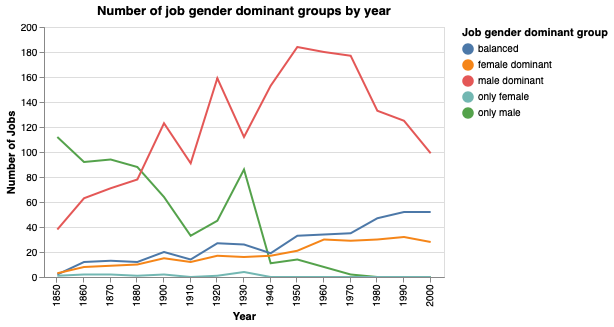

In [17]:
label = alt.selection_single(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty='none'     # empty selection includes no data points
)


gender_group_chart2_w_interaction = alt.layer(
    gender_group_chart2, # base line chart
        alt.Chart().mark_rule(color='#aaa').encode(
        x='year:O'
    ).transform_filter(label),
    gender_group_chart2.mark_circle().encode(
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),
    gender_group_chart2.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='total:Q'
    ).transform_filter(label),
     gender_group_chart2.mark_text(align='left', dx=5, dy=-5).encode(
        text='total:Q'
    ).transform_filter(label),
    data = gender_dominant_group_count_df
)
gender_group_chart2_w_interaction